In [1]:
import pandas as pd
import numpy as np
import os
import requests
import yaml

import matplotlib.pyplot as plt

In [2]:
yaml_path = 'data_for_visualizations.yaml'
with open(yaml_path) as file: 
    yaml_viz = yaml.load(file, Loader=yaml.FullLoader)

FileNotFoundError: [Errno 2] No such file or directory: 'data_for_visualizations.yaml'

## Get latest data

In [3]:
import update_crv_virtualprice as vp
import update_cvx_token_supply as ts
import update_cvx_rewardRate as rr

ImportError: cannot import name '_hash_eip191_message' from 'eip712.messages' (/Users/andrewgoldberg/opt/anaconda3/envs/web3/lib/python3.9/site-packages/eip712/messages.py)

In [ ]:
vp.connect()

### Start and End blocks for retreival

In [ ]:
# Start block
token_supply_files = [file for file in os.listdir('../data/cvx_token_supply') if file.split('.')[-1] == 'csv']
last_blocks = [file.split('.')[0].split('_')[3] for file in token_supply_files]
last_blocks.sort(reverse=True)
print(f'Last downloaded block: {last_blocks[0]}')
last_dl_block = int(last_blocks[0])

In [6]:
# End block
print(f'Current Eth block: {vp.chain.height}')
current_eth_block = vp.chain.height

Current Eth block: 16670643


In [ ]:
target_pools = ['alusd', 'susd', 'frax', 'mim', 'ousd', 'ironbank', 'fei', 'ust-wormhole']

In [8]:
print('retrieving virtual price data')
# vp.main(last_dl_block, current_eth_block)
print('retrieving token supply data')
ts.main()
print('retrieving reward rate and total supply data')
rr.main(last_dl_block, current_eth_block)

retrieving virtual price data
retrieving token supply data
contract doesnt exist at block 11565019
contract doesnt exist at block 11566710
contract doesnt exist at block 11568270
contract doesnt exist at block 11569949
contract doesnt exist at block 11571564
contract doesnt exist at block 11573230
contract doesnt exist at block 11574860
contract doesnt exist at block 11576488
contract doesnt exist at block 11578165
contract doesnt exist at block 11579719
contract doesnt exist at block 11581387
contract doesnt exist at block 11583018
contract doesnt exist at block 11584641
contract doesnt exist at block 11586256
contract doesnt exist at block 11587855
contract doesnt exist at block 11589502
contract doesnt exist at block 11591158
contract doesnt exist at block 11592771
contract doesnt exist at block 11594360
contract doesnt exist at block 11596020
contract doesnt exist at block 11597690
contract doesnt exist at block 11599264
contract doesnt exist at block 11600885
contract doesnt exist

OSError: Cannot save file into a non-existent directory: '../data/cvx_tokensupply'

# Import and organize historical data

In [8]:
# targeted_pools = ['frax', 'ousd', 'mim', 'susd', 'alusd', 'ust-wormhole', 'ironbank', 'fei']
# wormhole, ironbank and fei need more work

In [9]:
token_supply_files = [file for file in os.listdir('../data/cvx_token_supply') if file.split('.')[-1] == 'csv']
token_supply_dict = {}
for csv in token_supply_files:
    token_supply_dict[csv] = pd.read_csv(f'../data/cvx_token_supply/{csv}').rename(columns = {'Unnamed: 0': 'block'})

In [10]:
cvx_token_supply = pd.concat(token_supply_dict).reset_index().drop(['level_0', 'level_1'], axis = 1).rename(columns = {'totalSupply': 'cvxSupply', 'timeStamp': 'cvsSupply_ts'})
cvx_token_supply = cvx_token_supply.sort_values(by='block', ascending=True).reset_index(drop=True)
cvx_token_supply['cvxSupply'] = cvx_token_supply['cvxSupply'].astype(float)

In [11]:
virtual_price_csv_dict = {}
reward_supply_csv_dict = {}

virtual_price_df_dict = {}
reward_supply_df_dict = {}
df_dict = {}

for pool in targeted_pools:
    print(pool)
    virtual_price_csv_dict[pool] = {}
    reward_supply_csv_dict[pool] = {}

    virtual_price_files = [file for file in os.listdir(f'../data/virtualPrice/{pool}') if file.split('.')[-1] == 'csv']
    for csv in virtual_price_files:
        virtual_price_csv_dict[pool][csv] = pd.read_csv(f'../data/virtualPrice/{pool}/{csv}').rename(columns = {'Unnamed: 0': 'block'})
    virtual_price_df_dict[pool] = pd.concat(virtual_price_csv_dict[pool]).reset_index().drop(['level_0', 'level_1'], axis = 1).rename(columns = {'timeStamp': 'virtual_price_ts'})
    virtual_price_df_dict[pool]['timestamp'] = virtual_price_df_dict[pool].virtual_price_ts.apply(lambda x: pd.to_datetime(x, unit='s', utc=True))
    virtual_price_df_dict[pool]['date'] = virtual_price_df_dict[pool].virtual_price_ts.apply(lambda x: pd.to_datetime(x, unit='s', utc=True)).dt.date
    virtual_price_df_dict[pool]['date'] = virtual_price_df_dict[pool]['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

        
    reward_supply_files = [file for file in os.listdir(f'../data/rewardRate_totalSupply/{pool}') if file.split('.')[-1] == 'csv']
    for csv in reward_supply_files:
        reward_supply_csv_dict[pool][csv] = pd.read_csv(f'../data/rewardRate_totalSupply/{pool}/{csv}').rename(columns = {'Unnamed: 0': 'block'})
    reward_supply_df_dict[pool] = pd.concat(reward_supply_csv_dict[pool]).reset_index().drop(['level_0', 'level_1', 'timeStamp'], axis = 1)
    
    df_dict[pool] = pd.merge(reward_supply_df_dict[pool], virtual_price_df_dict[pool], how = 'left', on = 'block')
    df_dict[pool] = pd.merge(df_dict[pool], cvx_token_supply, how = 'left', on = 'block')

frax
ousd
mim
susd
alusd
ust-wormhole
ironbank
fei


# Calculate APR's

In [12]:
Decimal = 10 ** 18

crvAddress = "0xD533a949740bb3306d119CC777fa900bA034cd52";
cvxAddress = "0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B";
cvxCrvAddress = "0x62B9c7356A2Dc64a1969e19C23e4f579F9810Aa7";

cliffSize = 100000 # // * 1e18; //new cliff every 100,000 tokens
cliffCount = 1000 # // 1,000 cliffs
maxSupply = 100000000 # // * 1e18; //100 mil max supply

In [13]:
def getCVXMintAmount(pool_df):
    # //first get total supply
    # cvxSupply =  / Decimal
    # get current cliff
    currentCliff = (pool_df['cvxSupply'] / cliffSize)
    # print(f'currentCliff: {currentCliff}')
    # if current cliff is under the max
    if (currentCliff < cliffCount):
        # get remaining cliffs
        remaining = cliffCount - currentCliff
        # print(f'remaining: {remaining}')
        # multiply ratio of remaining cliffs to total cliffs against amount CRV received
        cvxEarned = pool_df['crvPerYear'] * remaining / cliffCount;

        # double check we have not gone over the max supply
        amountTillMax = maxSupply - pool_df['cvxSupply'];
        if (cvxEarned > amountTillMax):
            cvxEarned = amountTillMax
        return cvxEarned;
    return 0

In [14]:
def calculate_crv_cvx_perYear(pool_df_dict):
    
    pool_calcs_df_dict = {}

    for pool in pool_df_dict.keys():
        print(pool)
        pool_calcs_df_dict[pool] = pool_df_dict[pool].copy()

        # divide values by 10 ** 18
        pool_calcs_df_dict[pool]['rewardRate'] = pool_calcs_df_dict[pool]['rewardRate'].div(Decimal)
        pool_calcs_df_dict[pool]['totalSupply'] = pool_calcs_df_dict[pool]['totalSupply'].astype(float).div(Decimal)
        pool_calcs_df_dict[pool]['virtualPrice'] = pool_calcs_df_dict[pool]['virtualPrice'].astype(float).div(Decimal)
        pool_calcs_df_dict[pool]['cvxSupply'] = pool_calcs_df_dict[pool]['cvxSupply'].astype(float).div(Decimal)


        # calculations
        pool_calcs_df_dict[pool]['virtualSupply'] = pool_calcs_df_dict[pool]['virtualPrice'] * pool_calcs_df_dict[pool]['totalSupply']
        pool_calcs_df_dict[pool]['crvPerUnderlying'] = pool_calcs_df_dict[pool]['rewardRate'] / pool_calcs_df_dict[pool]['virtualSupply'] 
        pool_calcs_df_dict[pool]['crvPerYear'] = pool_calcs_df_dict[pool]['crvPerUnderlying'] * 86400 * 365
        
        # print(pool_calcs_df_dict[pool].apply(getCVXMintAmount, axis=1))
        
        pool_calcs_df_dict[pool]['cvxPerYear'] = pool_calcs_df_dict[pool].apply(getCVXMintAmount, axis=1)
        
    return(pool_calcs_df_dict)

In [15]:
# pool_calcs_df_dict = {}

# for pool in df_dict.keys():
#     print(pool)
#     pool_calcs_df_dict[pool] = df_dict[pool].copy()

#     # divide values by 10 ** 18
#     pool_calcs_df_dict[pool]['rewardRate'] = pool_calcs_df_dict[pool]['rewardRate'].div(Decimal)
#     pool_calcs_df_dict[pool]['totalSupply'] = pool_calcs_df_dict[pool]['totalSupply'].astype(float).div(Decimal)
#     pool_calcs_df_dict[pool]['virtualPrice'] = pool_calcs_df_dict[pool]['virtualPrice'].astype(float).div(Decimal)
#     pool_calcs_df_dict[pool]['cvxSupply'] = pool_calcs_df_dict[pool]['cvxSupply'].astype(float).div(Decimal)


#     # calculations
#     pool_calcs_df_dict[pool]['virtualSupply'] = pool_calcs_df_dict[pool]['virtualPrice'] * pool_calcs_df_dict[pool]['totalSupply']
#     pool_calcs_df_dict[pool]['crvPerUnderlying'] = pool_calcs_df_dict[pool]['rewardRate'] / pool_calcs_df_dict[pool]['virtualSupply'] 
#     pool_calcs_df_dict[pool]['crvPerYear'] = pool_calcs_df_dict[pool]['crvPerUnderlying'] * 86400 * 365

In [16]:
calc_dict = calculate_crv_cvx_perYear(df_dict)

frax
ousd
mim
susd
alusd
ust-wormhole
ironbank
fei


### Get CRV / CVX Historical Pricing

In [17]:
def get_crv_cvx_historical_price(days=365):
    
    vsCoin = "USD"
    cvx_id = "convex-finance"
    crv_id = "curve-dao-token"

    # current market prices
    # crv_current_url = "https://api.coingecko.com/api/v3/simple/token_price/ethereum?contract_addresses=" + crvAddress + "&vs_currencies=" + vsCoin;
    # cvx_current_url = "https://api.coingecko.com/api/v3/simple/token_price/ethereum?contract_addresses=" + cvxAddress + "&vs_currencies=" + vsCoin;

    # historical market prices
    cvx_hist_url = f"https://api.coingecko.com/api/v3/coins/{cvx_id}/market_chart?vs_currency={vsCoin}&days={days}"
    crv_hist_url = f"https://api.coingecko.com/api/v3/coins/{crv_id}/market_chart?vs_currency={vsCoin}&days={days}"
    
    cvx_hist_price_requests = requests.get(cvx_hist_url)
    crv_hist_price_requests = requests.get(crv_hist_url)
    
    crv_price_hist = crv_hist_price_requests.json()['prices']
    cvx_price_hist = cvx_hist_price_requests.json()['prices']
    
    crv_price_df = pd.DataFrame(crv_price_hist, columns = ['ux_datetime', 'crv_price'])
    cvx_price_df = pd.DataFrame(cvx_price_hist, columns = ['ux_datetime', 'cvx_price'])
    
    price_hist_df = pd.merge(crv_price_df, cvx_price_df, on = 'ux_datetime')
    
    price_hist_df['date'] = price_hist_df.ux_datetime.apply(lambda x: pd.to_datetime(x, unit='ms', utc=True).strftime("%Y-%m-%d"))
    
    return(price_hist_df)

In [18]:
def join_pricing_blockchain_data(price_hist_df, pool_calcs_df_dict):
    
    # price_block_df = pd.merge(price_hist_df, block_timestamp_df, on = 'date', how = 'left').drop(['ux_datetime', 'timestamp'], axis = 1)
    
    # price_block_nona_df = price_block_df.dropna()
    # price_block_nona_df['block'] = price_block_nona_df['block'].astype(int)
    
    for pool in pool_calcs_df_dict.keys():
        # print(pool)
        pool_calcs_df_dict[pool] = pd.merge(price_hist_df, pool_calcs_df_dict[pool].copy(), on = 'date', how = 'right')
        pool_calcs_df_dict[pool] = pool_calcs_df_dict[pool].drop_duplicates('date', keep = 'last')
    
    return(pool_calcs_df_dict)

In [19]:
def calculate_apy(pool_calcs_df_dict):
    
    for pool in pool_calcs_df_dict.keys():
        # print(pool)
        # rewards apy
        pool_calcs_df_dict[pool]['crv_apy'] = pool_calcs_df_dict[pool]['crvPerYear'] * pool_calcs_df_dict[pool]['crv_price']
        pool_calcs_df_dict[pool]['cvx_apy'] = pool_calcs_df_dict[pool]['cvxPerYear'] * pool_calcs_df_dict[pool]['cvx_price']
        pool_calcs_df_dict[pool]['rewards_apy'] = pool_calcs_df_dict[pool]['crv_apy'] + pool_calcs_df_dict[pool]['cvx_apy']

        # base apy
        pool_calcs_df_dict[pool]['base_apr'] = (pool_calcs_df_dict[pool].virtualPrice - pool_calcs_df_dict[pool].virtualPrice.shift(1)) / pool_calcs_df_dict[pool].virtualPrice.shift(1)
        pool_calcs_df_dict[pool]['base_apy'] = ((1 + pool_calcs_df_dict[pool].base_apr) ** 365) - 1

        # total apy
        pool_calcs_df_dict[pool]['total_apy'] = pool_calcs_df_dict[pool]['rewards_apy'] + pool_calcs_df_dict[pool]['base_apy']
        
        pool_calcs_df_dict[pool].date = pd.to_datetime(pool_calcs_df_dict[pool].date, format='%Y-%m-%d')
        
    return(pool_calcs_df_dict)

In [20]:
def main(pool_df_dict):
    
    pool_calcs_df_dict = calculate_crv_cvx_perYear(pool_df_dict)
    price_hist_df = get_crv_cvx_historical_price(days=365)
    # block_timestamp_df = get_block_timestamp_data()
    
    pool_calcs_df_dict = join_pricing_blockchain_data(price_hist_df, pool_calcs_df_dict)
    
    pool_calcs_df_dict = calculate_apy(pool_calcs_df_dict)
    
    return(pool_calcs_df_dict)

In [21]:
apys_for_viz = main(df_dict)

frax
ousd
mim
susd
alusd
ust-wormhole
ironbank
fei


## Visualizations

In [22]:
def visualize_apy(name, data):
    df = data_.sort_values(by = 'date')
    df['7d_Total_APY'] = df.total_apy.rolling(7).mean()
    df['30d_Total_APY'] = df.total_apy.rolling(30).mean()

    # line plots
    fig, axs = plt.subplots(2, 1)
    fig.suptitle(name, fontsize = 20)
    
    axs[0].set_title('APYs')
    axs[0].plot('date', 'base_apy', data = df)
    axs[0].plot('date', 'rewards_apy', data = df)
    axs[0].plot('date', 'total_apy', data = df)
    axs[0].legend()   

    axs[1].set_title('Moving Averages')
    axs[1].plot('date', '7d_Total_APY', data=df)
    axs[1].plot('date', '30d_Total_APY', data=df)
    axs[1].plot('date', 'total_apy', data=df)
    axs[1].legend()

    fig.set_size_inches(18.5, 10.5)
    plt.show()

### Pick pools here (only in-use pools available right now)

In [23]:
apy_strategies_ma = ['frax', 'ousd', 'mim', 'susd', 'alusd', 'ust-wormhole', 'ironbank']
# fei breaks at 14 days

In [24]:
pool_apy_date = pd.concat(apys_for_viz)[['total_apy', 'date']].reset_index().rename(columns = {'level_0': 'pool'}).drop('level_1', axis = 1)
pool_apy_date = pool_apy_date.pivot(index = 'date', columns='pool', values = 'total_apy')[apy_strategies_ma]

In [25]:
# rolling average calculations
pool_apy_ma_dict = {}
pool_apy_ma_dict[7] = pool_apy_date.rolling(7).mean()
pool_apy_ma_dict[14] = pool_apy_date.rolling(14).mean()
pool_apy_ma_dict[30] = pool_apy_date.rolling(30).mean()

ma_dict = {}
for avg in pool_apy_ma_dict.keys():
    print(avg)
    ma_dict[avg] = pool_apy_ma_dict[avg].dropna().iloc[-1].sort_values(ascending=False).mul(100).round(2)

7
14
30


In [26]:
pd.concat(ma_dict, axis = 1).reset_index().sort_values(by = 7, ascending=False)

,pool,7,14,30
0,ust-wormhole,12.26,12.55,15.77
1,mim,11.55,11.64,14.00
2,alusd,7.40,8.00,7.27
3,frax,7.33,7.75,8.72
4,ironbank,5.74,6.08,7.36
5,susd,5.42,5.41,6.28
6,ousd,4.56,4.55,7.56


## 7 Day Moving Average

In [27]:
# most recent day's data
pool_apy_ma_dict[7].dropna().iloc[-1].sort_values(ascending=False).mul(100).round(2)

pool
ust-wormhole    12.26
mim             11.55
alusd            7.40
frax             7.33
ironbank         5.74
susd             5.42
ousd             4.56
Name: 2022-03-03 00:00:00, dtype: float64

<AxesSubplot:xlabel='date'>

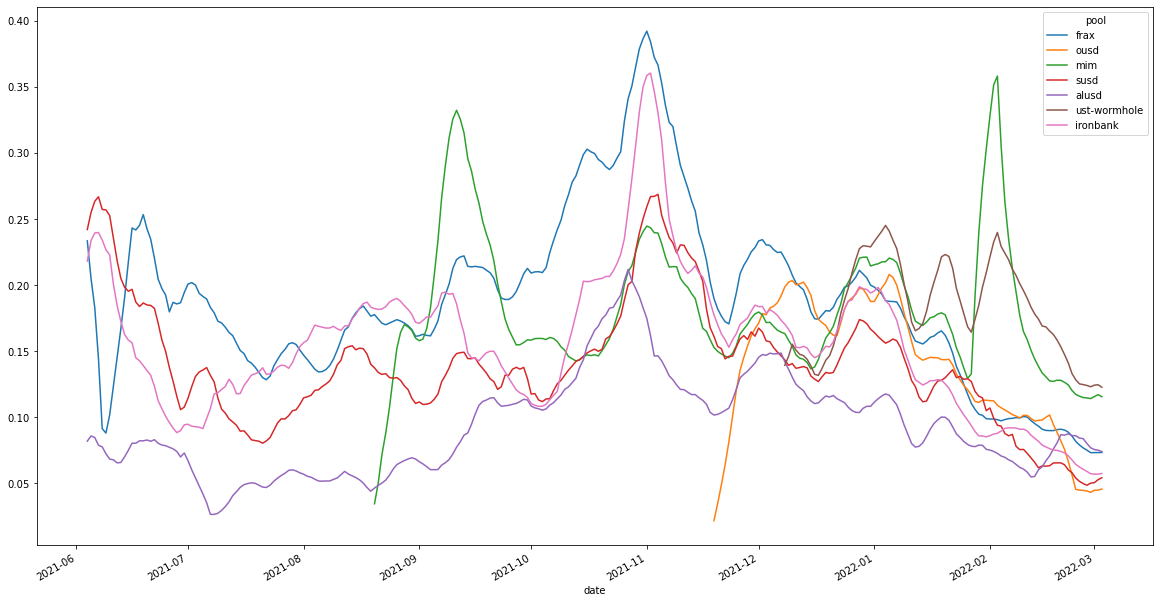

In [28]:
pool_apy_ma_dict[7].plot(figsize = (20,11))

## 14 Day Moving Average

In [29]:
# most recent day's data
pool_apy_ma_dict[14].dropna().iloc[-1].sort_values(ascending=False).mul(100).round(2)

pool
ust-wormhole    12.55
mim             11.64
alusd            8.00
frax             7.75
ironbank         6.08
susd             5.41
ousd             4.55
Name: 2022-03-03 00:00:00, dtype: float64

<AxesSubplot:xlabel='date'>

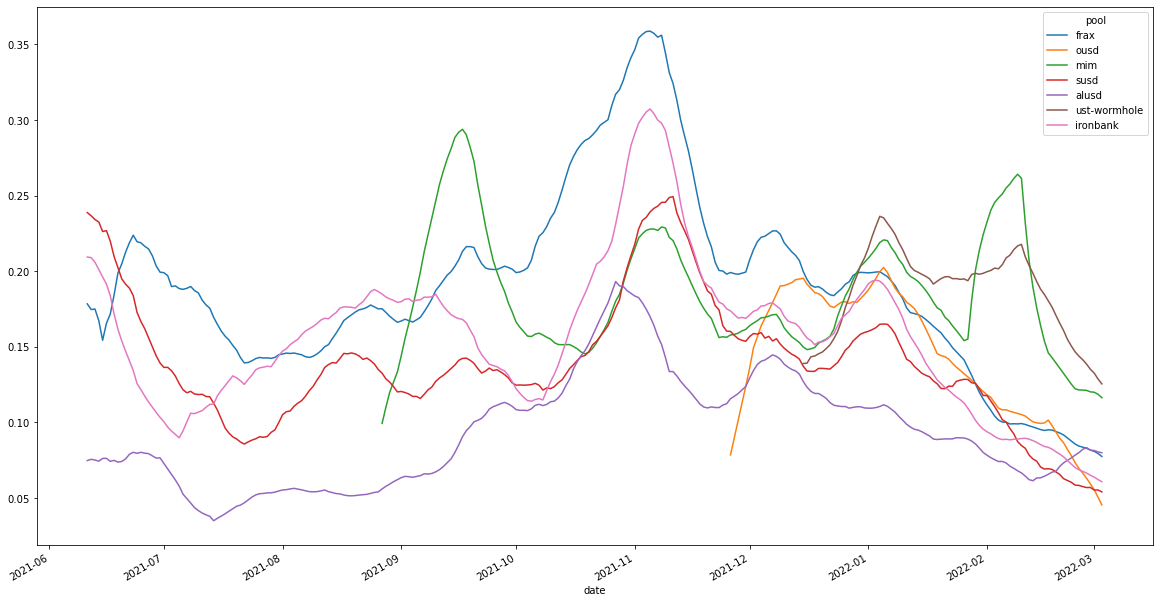

In [30]:
pool_apy_ma_dict[14].plot(figsize = (20,11))

## 30 Day Moving Average

In [31]:
# most recent day's data
pool_apy_ma_dict[30].dropna().iloc[-1].sort_values(ascending=False).mul(100).round(2)

pool
ust-wormhole    15.77
mim             14.00
frax             8.72
ousd             7.56
ironbank         7.36
alusd            7.27
susd             6.28
Name: 2022-03-03 00:00:00, dtype: float64

<AxesSubplot:xlabel='date'>

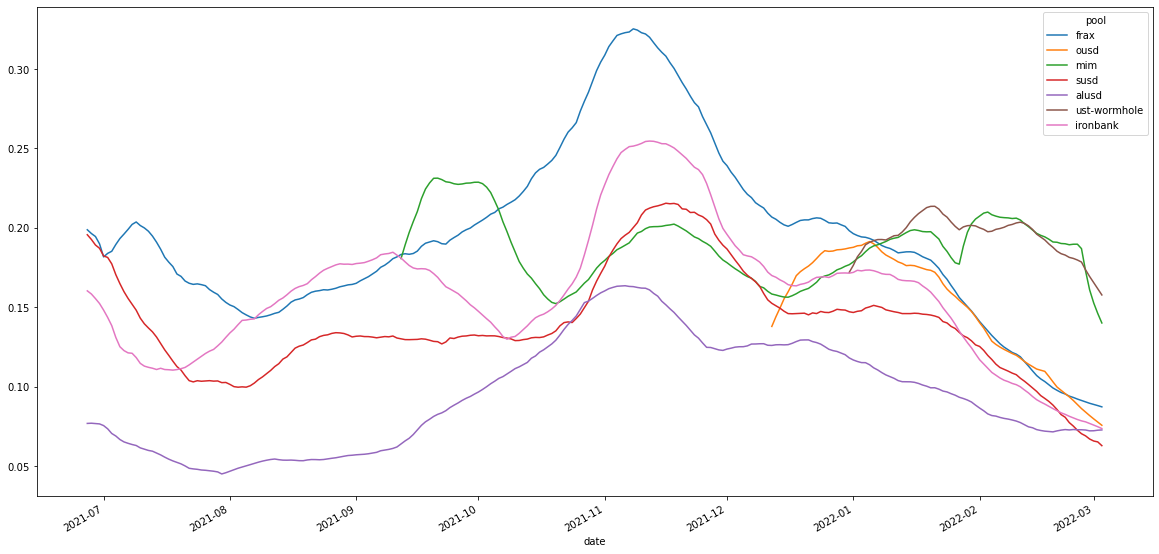

In [32]:
pool_apy_ma_dict[30].plot(figsize = (20,10))

## Pool Specific Views

In [33]:
apy_strategies = ['frax', 'ousd', 'mim', 'susd', 'alusd', 'ust-wormhole', 'ironbank', 'fei']
# fei breaks at 30 days

frax


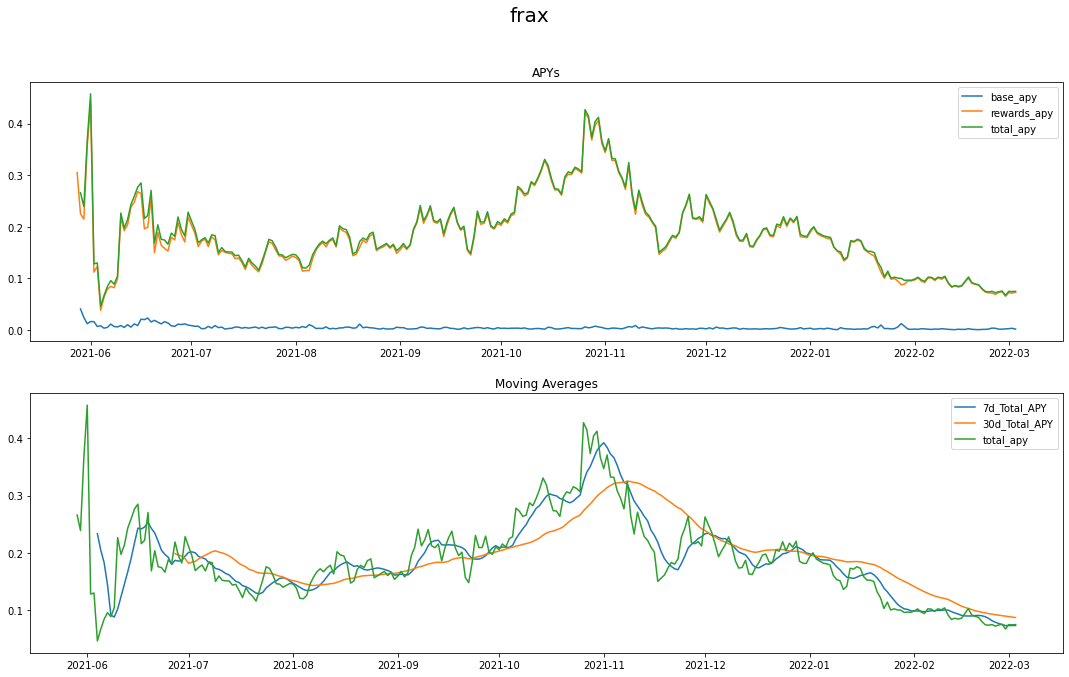

ousd


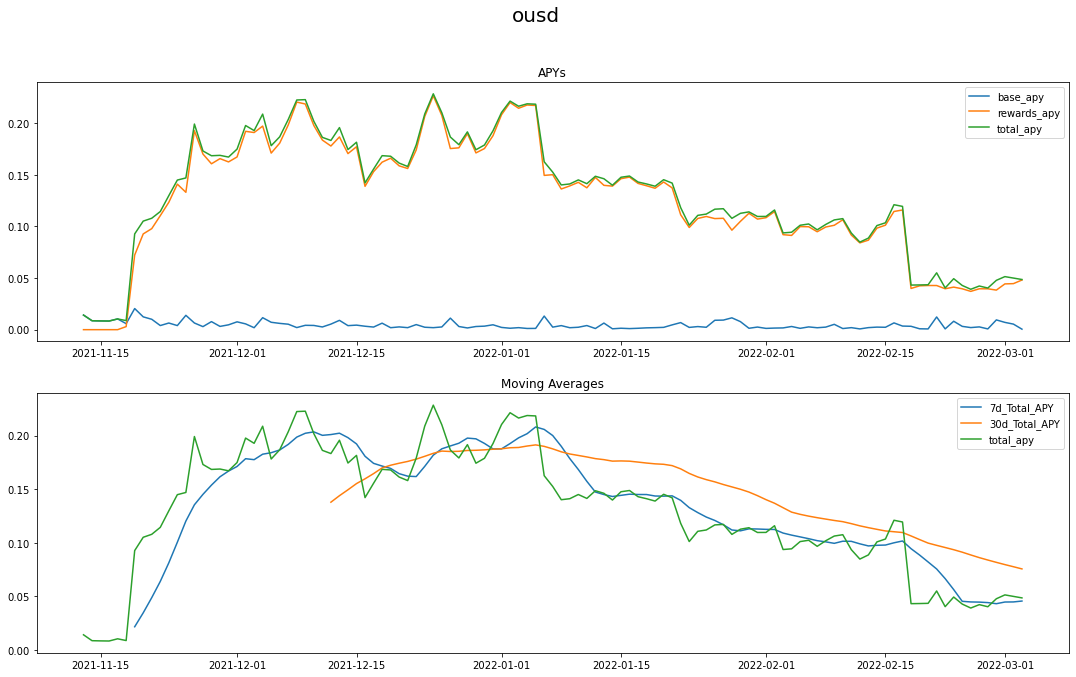

mim


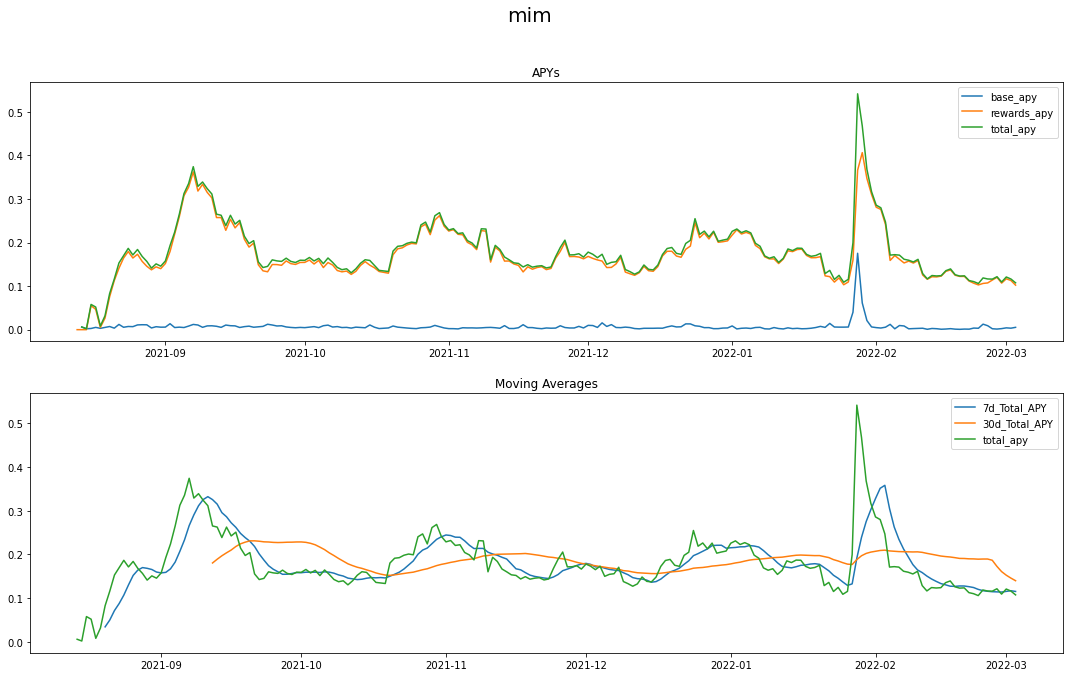

susd


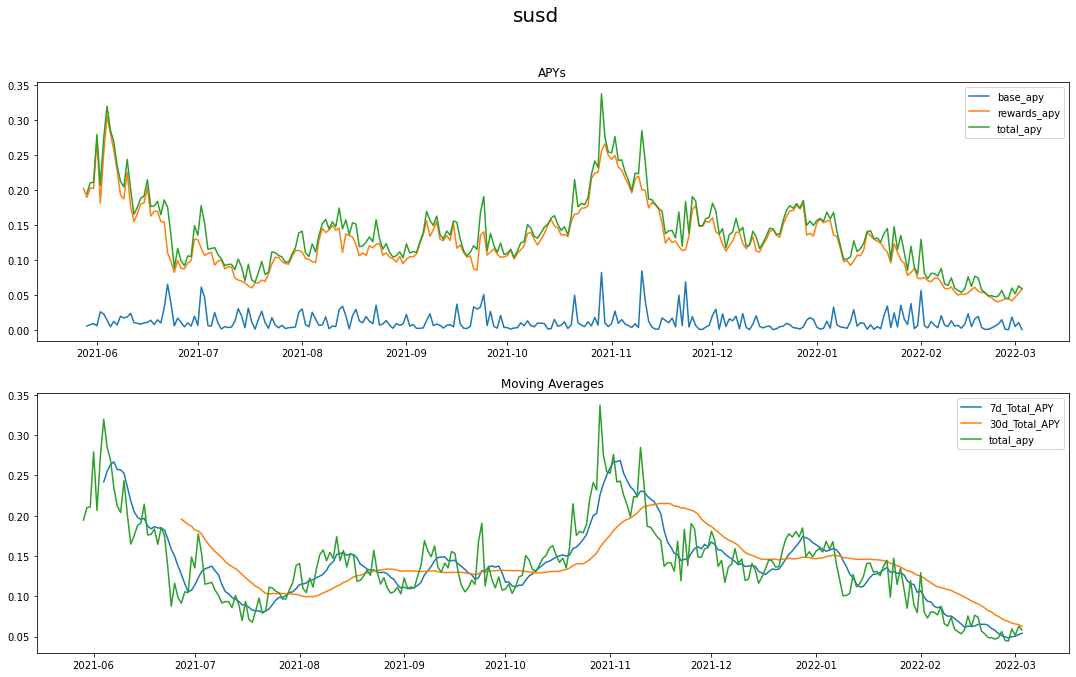

alusd


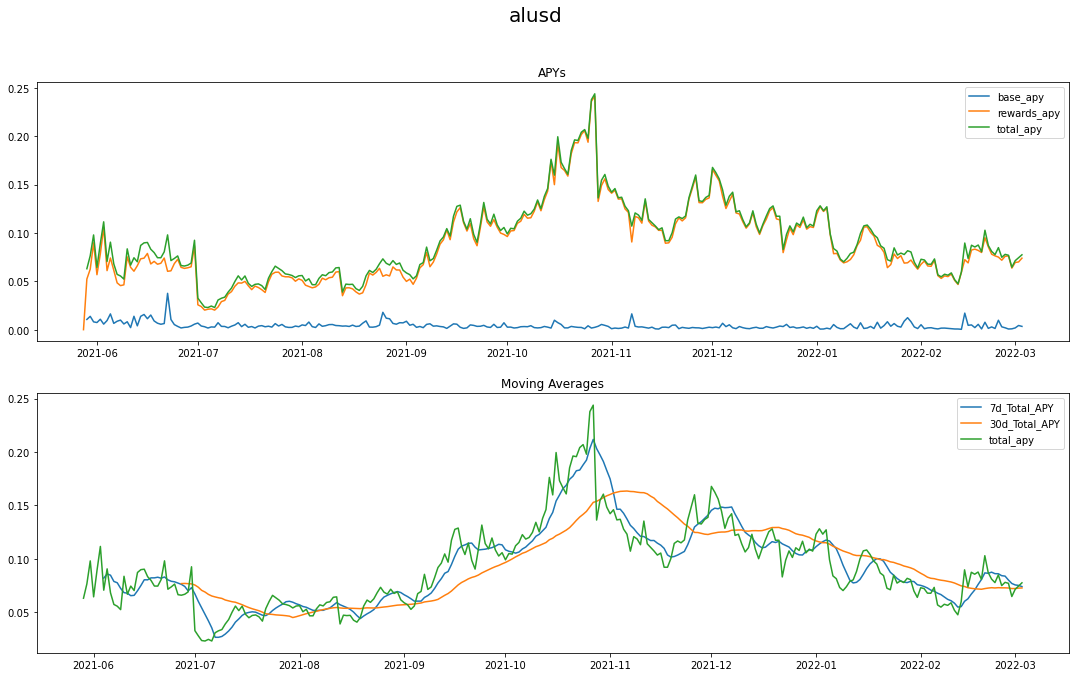

ust-wormhole


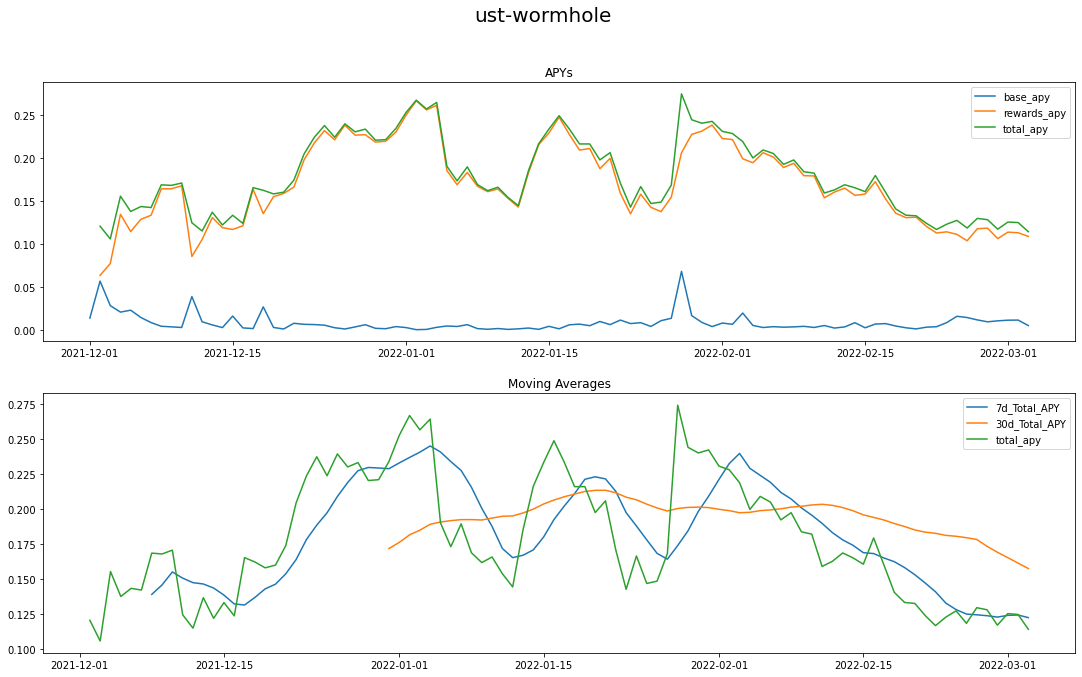

ironbank


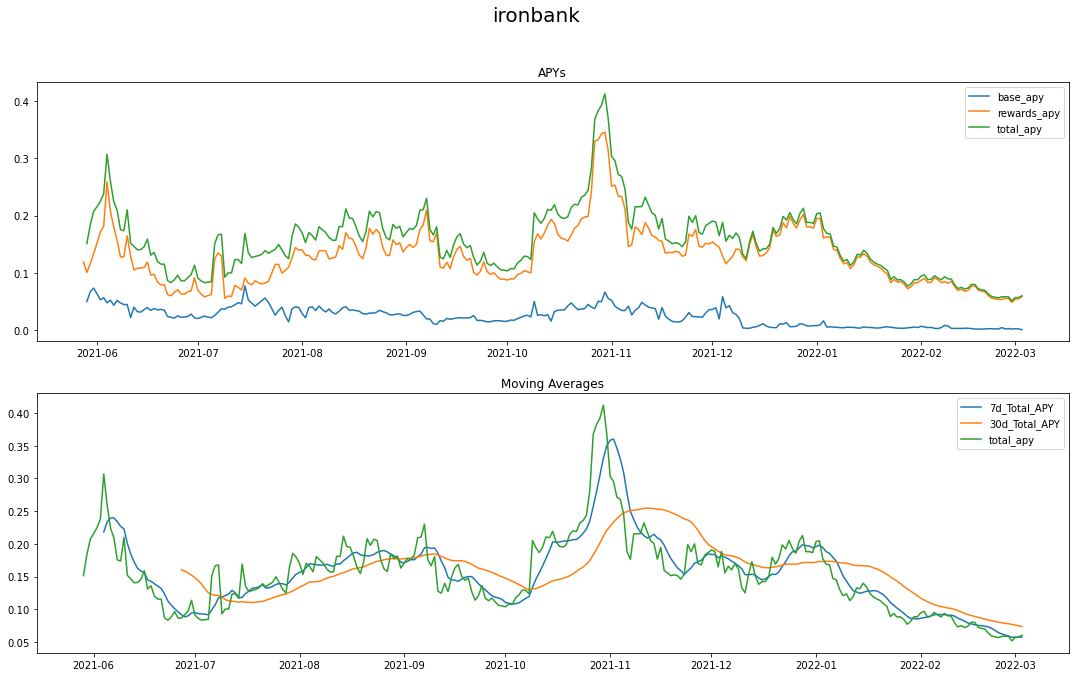

fei


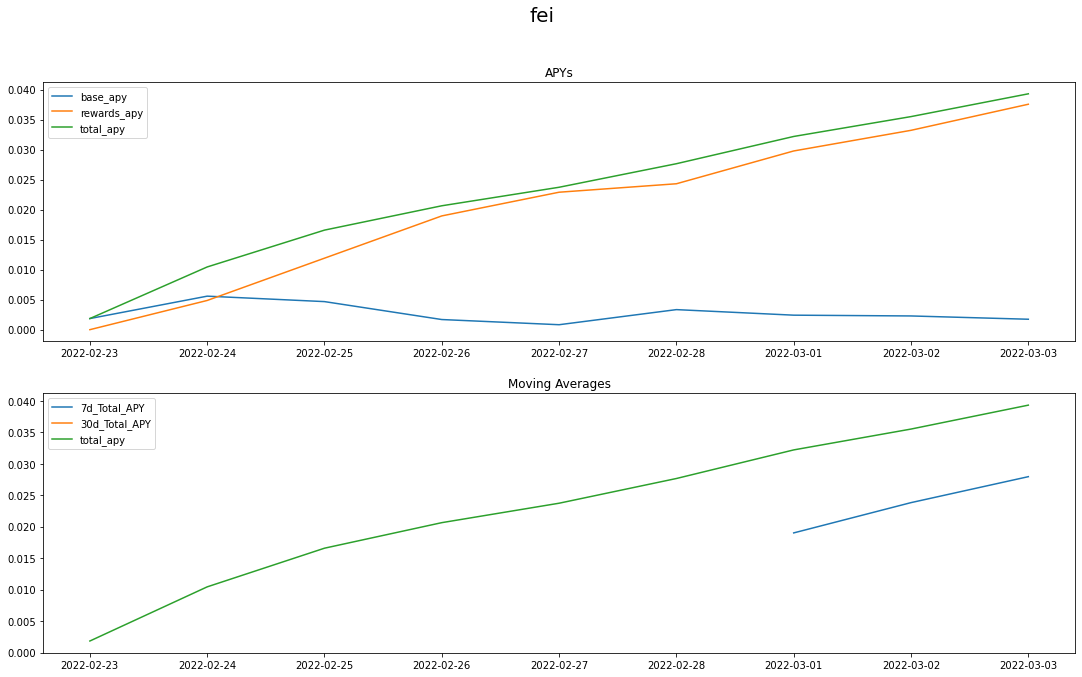

In [34]:
for pool in apy_strategies:
    print(pool)
    data_ = apys_for_viz[pool]
    visualize_apy(f'{pool}', data_)